<a href="https://colab.research.google.com/github/Dasika-Vaishnavi/Wave2Web_forecast/blob/main/Wave2web_outliers_eloborate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import warnings; 
warnings.simplefilter('ignore')

In [18]:
!pip install pandas
!pip install prophet

# 0. Install and import dependencies

In [19]:
import pandas as pd
from prophet import Prophet

# 1. Read and process data

In [36]:
df = pd.read_csv('/content/picchi_peaks.csv')
df['Year'] = df['FLOW_DATE'].apply(lambda x: str(x)[-4:])
df['Month'] = df['FLOW_DATE'].apply(lambda x: str(x)[-6:-4])
df['Day'] = df['FLOW_DATE'].apply(lambda x: str(x)[:-6])
df['ds'] = pd.DatetimeIndex(df['Day']+'-'+df['Year'])
df.drop(['FLOW_DATE', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.head()

,y,ds
0,46.42,2011-01-01
1,46.54,2011-01-01
2,46.64,2011-01-01
3,46.69,2011-01-01
4,46.70,2011-01-01


# 2. Train the model

In [37]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(df)

# 3. Forecasting the data

In [38]:
future = m.make_future_dataframe(periods=100,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-03,46.058854,45.633372,70.003411,46.058854,46.058854,11.620017,11.620017,11.620017,1.036155,1.036155,1.036155,0.193177,0.193177,0.193177,10.390685,10.390685,10.390685,0.0,0.0,0.0,57.678871
1,2010-12-03,42.335766,37.847051,62.413921,42.335766,42.335766,7.113038,7.113038,7.113038,1.036155,1.036155,1.036155,0.193177,0.193177,0.193177,5.883706,5.883706,5.883706,0.0,0.0,0.0,49.448804
2,2011-01-01,41.149287,32.468721,58.232895,41.149287,41.149287,4.769734,4.769734,4.769734,1.036155,1.036155,1.036155,0.076082,0.076082,0.076082,3.657498,3.657498,3.657498,0.0,0.0,0.0,45.919021
3,2011-01-02,41.108374,33.979227,57.165635,41.108374,41.108374,4.555793,4.555793,4.555793,1.036155,1.036155,1.036155,0.305051,0.305051,0.305051,3.214588,3.214588,3.214588,0.0,0.0,0.0,45.664167
4,2011-01-03,41.067461,32.602509,57.454095,41.067461,41.067461,4.011792,4.011792,4.011792,1.036155,1.036155,1.036155,0.351497,0.351497,0.351497,2.624141,2.624141,2.624141,0.0,0.0,0.0,45.079253


# 4. Outlier

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


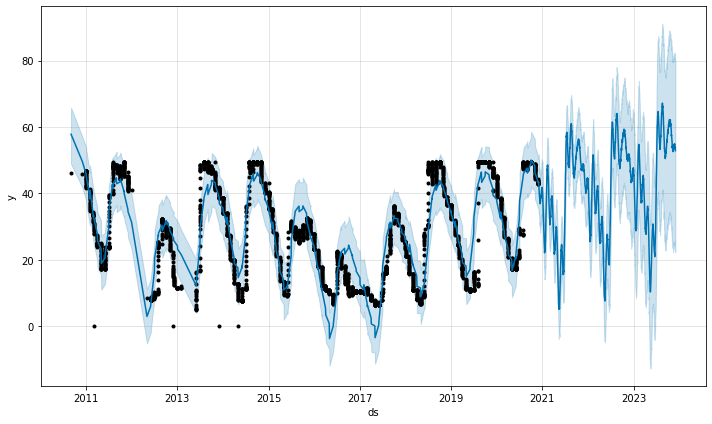

In [39]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

### The trend forecast seems reasonable, but the uncertainty intervals seem way too wide. Prophet is able to handle the outliers in the history, but only by fitting them with trend changes. The uncertainty model then expects future trend changes of similar magnitude.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


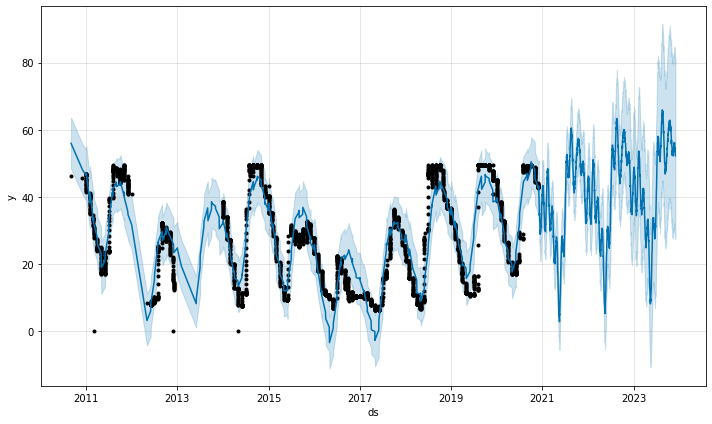

In [40]:
df.loc[(df['ds'] > '2013-01-01') & (df['ds'] < '2014-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


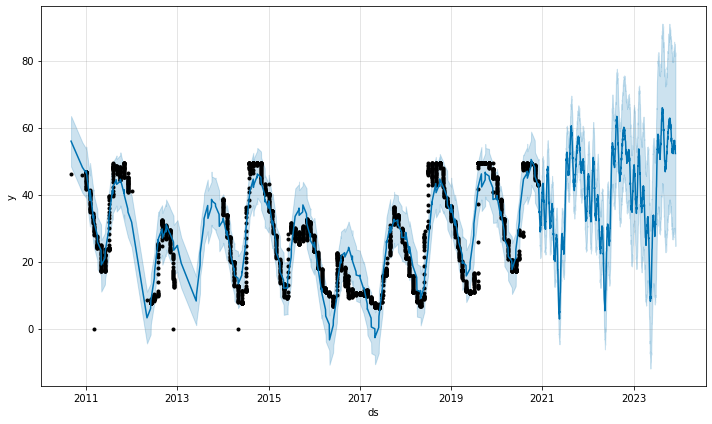

In [41]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


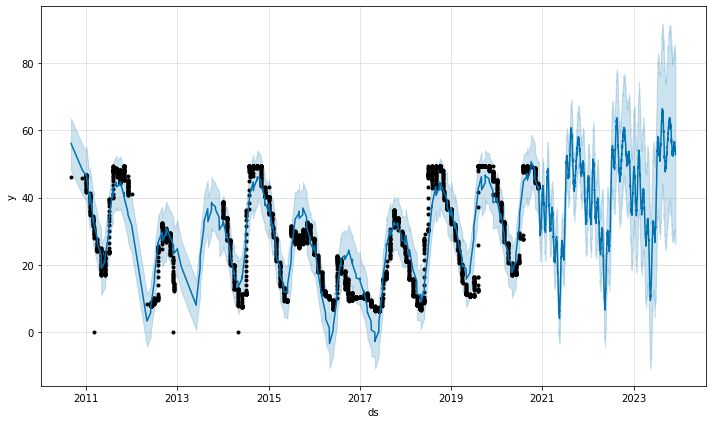

In [42]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))

# 4.1 Sub-daily data
### Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the ds column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


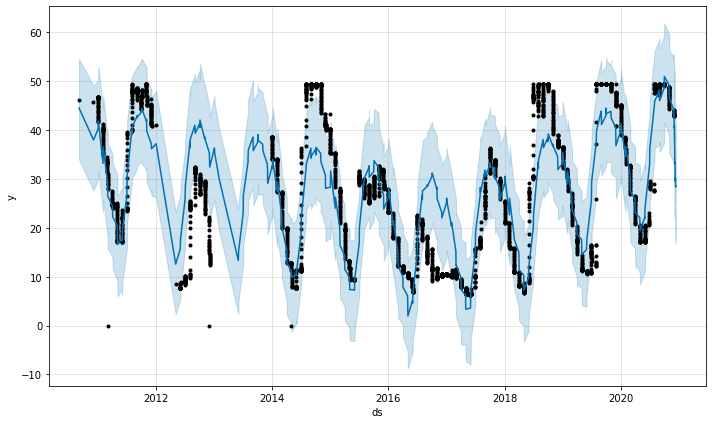

In [43]:
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

### The daily seasonality will show up in the components plot

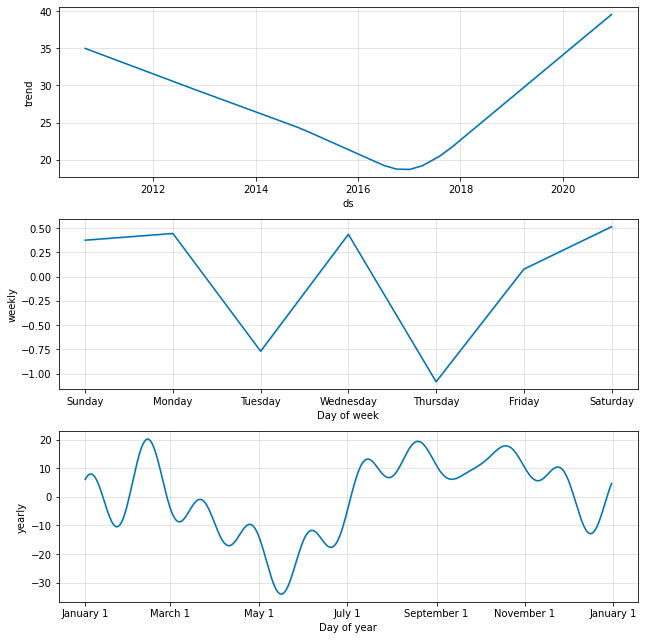

In [44]:
fig = m.plot_components(fcst)

# 4.2 Data with regular gaps

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


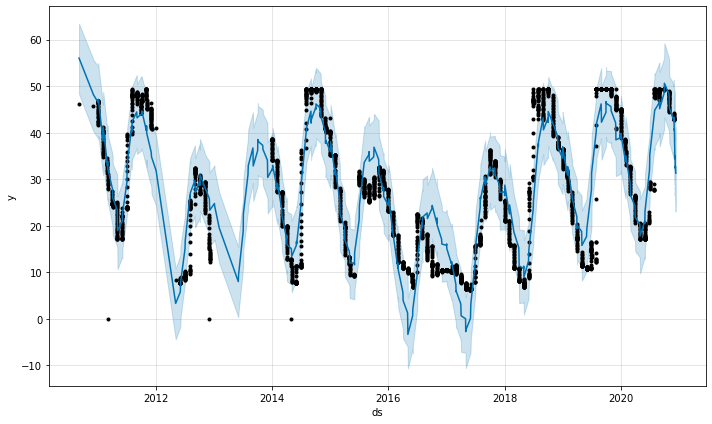

In [45]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

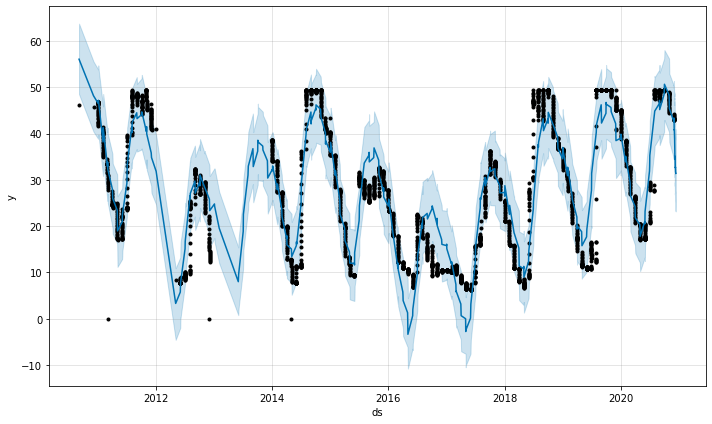

In [46]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

# 4.3 Monthly data
### You can use Prophet to fit monthly data. However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts.



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


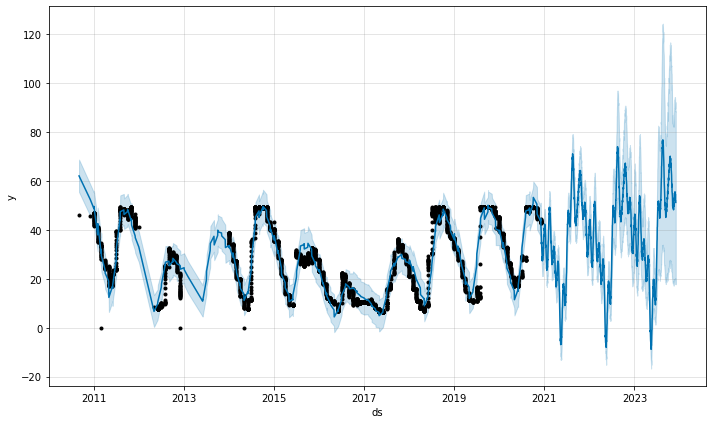

In [47]:
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=1096)
fcst = m.predict(future)
fig = m.plot(fcst)

### The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into make_future_dataframe

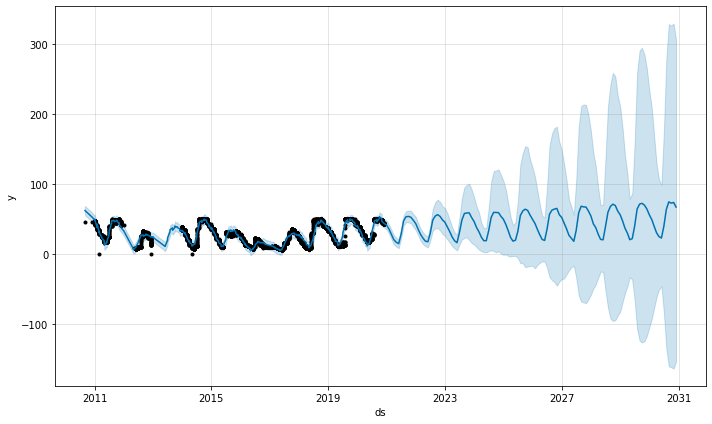

In [48]:
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### This is the same issue from above where the dataset has regular gaps. When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. This can be clearly seen by doing MCMC to see uncertainty in the seasonality